In [7]:
## Figure 02 - Characteristics of Unwrapping Errors
%matplotlib inline
import os
import sys
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt, ticker
from matplotlib.gridspec import GridSpec
from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits.axes_grid1 import make_axes_locatable
from pysar.simulation.plot import *
from pysar.objects import timeseries, ifgramStack, sensor
from pysar.utils import readfile, writefile, ptime, plot as pp, utils as ut, network as pnet
from pysar import view


work_dir = os.path.expanduser('~/insarlab/Galapagos/GalapagosSenDT128/PYSAR')
os.chdir(work_dir)
print('Go to directory: '+work_dir)

Go to directory: /Users/yunjunz/insarlab/Galapagos/GalapagosSenDT128/PYSAR


In [8]:
# calculate the closure phase

idx_closure = 23

ifgram_file = os.path.join(work_dir, 'INPUTS/ifgramStack.h5')
mask_file   = os.path.join(work_dir, 'waterMask.h5')
mask = readfile.read(mask_file)[0]

stack_obj = ifgramStack(ifgram_file)
stack_obj.open(print_msg=False)
length, width = stack_obj.length, stack_obj.width
ref_y, ref_x = stack_obj.refY, stack_obj.refX
date12_list = stack_obj.date12List
C = ifgramStack.get_design_matrix4triplet(date12_list)
print('number of interferograms: {}'.format(C.shape[1]))
print('number of triplets: {}'.format(C.shape[0]))

idx_ifgs = np.where(C[idx_closure, :])[0]
ifgram = np.zeros((3, length, width), np.float32)
for i in range(3):
    dsName = 'unwrapPhase-{}'.format(date12_list[idx_ifgs[i]])
    print(dsName)
    data = readfile.read(ifgram_file, datasetName=dsName, print_msg=False)[0]
    data -= data[ref_y, ref_x]
    ifgram[i, :, :] = data

closure_phase = ifgram[0, :, :] - ifgram[1, :, :] + ifgram[2, :, :]
closure_phase[mask == 0] = np.nan
int_closure_phase = closure_phase - ut.wrap(closure_phase)
print('Done.')

number of interferograms: 475
number of triplets: 940
unwrapPhase-20150307_20150319
unwrapPhase-20150307_20150506
unwrapPhase-20150319_20150506
Done.


DESCENDING orbit
flip figure left and right
save figure to file /Users/yunjunz/insarlab/Galapagos/GalapagosSenDT128/PYSAR/closure_phase_stats.png


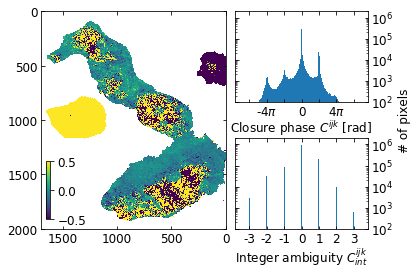

In [28]:
# plot Fig.2 a-c

fig = plt.figure(figsize=(6, 4))
gs = GridSpec(nrows=2, ncols=5, figure=fig)
ax1 = fig.add_subplot(gs[:,:3])
ax2 = fig.add_subplot(gs[0,3:])
ax3 = fig.add_subplot(gs[1,3:])

# subplot 1
vlim = 0.5
im = ax1.imshow(closure_phase, cmap=plt.cm.get_cmap('viridis', lut=256), vmin=-1.*vlim, vmax=vlim)
# axis format
pp.auto_flip_direction(stack_obj.metadata, ax1)
ax1.tick_params(which='both', direction='in', labelsize=font_size, bottom=True, top=True, left=True, right=True)
#ax1.set_xlabel('Range pix.', fontsize=font_size)
#ax1.set_ylabel('Azimuth pix.', fontsize=font_size)
ax1.set_ylim(length+0.5, 0.5)
ax1.yaxis.set_major_locator(ticker.LinearLocator(5))
# colorbar
cax = fig.add_axes([0.155, 0.16, 0.01, 0.2])
cbar = plt.colorbar(im, cax=cax, ticks=[-vlim, 0, vlim])
cbar.ax.tick_params(labelsize=font_size)
#cbar.set_label('Phase [rad]', fontsize=font_size, labelpad=-0.1)

# subplots 2 & 3
xmax = 24
bins = np.arange(-24.11, -0.1, 0.2).tolist() + np.arange(0.1, 24, 0.2).tolist()
ax2.hist(closure_phase[mask].flatten(),     range=(-1*xmax, xmax), bins=xmax*20, log=True);
ax3.hist(int_closure_phase[mask].flatten(), range=(-1*xmax, xmax), bins=bins,    log=True);

# axis format
for ax in [ax2, ax3]:
    ax.set_xlim([-xmax, xmax])
    ax.set_ylim([1e2, 2e6])
    ax.set_xticks([-6*np.pi, -4*np.pi, -2*np.pi, 0, 2*np.pi, 4*np.pi, 6*np.pi])
    ax.yaxis.tick_right()
    ax.yaxis.set_major_locator(ticker.LogLocator(base=10.0, numticks=15))
    ax.yaxis.set_minor_locator(ticker.LogLocator(base=10.0, numticks=15, subs=(0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9)))
    ax.yaxis.set_minor_formatter(ticker.NullFormatter())
    ax.tick_params(which='both', direction='in', labelsize=font_size, bottom=True, top=True, left=True, right=True)

#ax2.set_xticklabels([])
ax2.set_xticklabels(['', r'-4$\pi$', '', '0', '', r'4$\pi$', ''])
ax2.set_xlabel(r'Closure phase $C^{ijk}$ [rad]', fontsize=font_size, labelpad=0)
ax3.set_xticklabels(['-3', '-2', '-1', '0', '1', '2', '3'])
ax3.set_xlabel(r'Integer ambiguity $C^{ijk}_{int}$', fontsize=font_size, labelpad=0)
pp.set_shared_ylabel([ax2, ax3], '# of pixels', font_size=font_size, position='right', labelpad=1)
fig.subplots_adjust(wspace=0.03, hspace=0.4)

# output
out_file = os.path.join(work_dir, 'closure_phase_stats.png')
plt.savefig(out_file, bbox_inches='tight', transparent=True, dpi=fig_dpi)
print('save figure to file', out_file)
plt.show()

DESCENDING orbit
flip figure left and right
save figure to file /Users/yunjunz/insarlab/Galapagos/GalapagosSenDT128/PYSAR/num_int_ambiguity.png


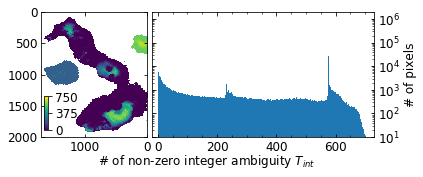

In [26]:
## Fig. 2 e-f

# read data
num_file = os.path.join(work_dir, 'UNW_COR/numPhaClosureJump_unwrapPhase.h5')
num_closure_jump = np.array(readfile.read(num_file)[0], np.float32)
num_closure_jump[mask == 0] = np.nan
vmax = 750

fig = plt.figure(figsize=(6, 2.3))
gs = GridSpec(nrows=1, ncols=3, figure=fig)
ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[0,1:])

# axes 1 - map
im = ax1.imshow(num_closure_jump, cmap='viridis', vmin=0, vmax=vmax)
pp.auto_flip_direction(stack_obj.metadata, ax1)
# colorbar
cax = fig.add_axes([0.135, 0.17, 0.01, 0.2])
cbar = plt.colorbar(im, cax=cax, ticks=[0, vmax/2, vmax])
cbar.ax.tick_params(labelsize=font_size)
#cbar.set_label('Phase [rad]', fontsize=font_size, labelpad=-0.1)

# axes 2 - histogram
ax2.hist(num_closure_jump[~np.isnan(num_closure_jump)].flatten(), range=(0, vmax), log=True, bins=vmax)
# axis format
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position("right")
ax2.set_xlim(-20,vmax-20)
ax2.set_ylim(1e1, 2e6)
pp.set_shared_xlabel([ax1, ax2], r'# of non-zero integer ambiguity $T_{int}$', labelpad=-0.03, font_size=font_size, position='bottom')
#ax2.set_xlabel('# of non-zero integer ambiguity', fontsize=font_size)
ax2.set_ylabel('# of pixels', fontsize=font_size)
ax2.xaxis.set_minor_locator(ticker.AutoMinorLocator())
ax2.yaxis.set_major_locator(ticker.LogLocator(base=10.0, numticks=15))
ax2.yaxis.set_minor_locator(ticker.LogLocator(base=10.0, numticks=15, subs=(0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9)))
ax2.yaxis.set_minor_formatter(ticker.NullFormatter())
for ax in [ax1, ax2]:
    ax.tick_params(which='both', direction='in', labelsize=font_size, bottom=True, top=True, left=True, right=True)
fig.subplots_adjust(wspace=0.03)

# save
out_fig = os.path.join(work_dir, 'num_int_ambiguity.png')
plt.savefig(out_fig, bbox_inches='tight', transparent=True, dpi=fig_dpi)
print('save figure to file', out_fig)
plt.show()

In [11]:
np.nanmin(num_closure_jump), np.nanmax(num_closure_jump)

(0.0, 714.0)